In [1]:

import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Import PyTorch dependencies
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

%matplotlib inline

In [2]:
os.makedirs('mnist_data', exist_ok=True)
os.makedirs('generated_images', exist_ok=True)

In [3]:
custom_image_path = None
batch_size = 128
image_size = 28
#---------------------------

# Resize data
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Grayscale(),
    transforms.ToTensor()
])

if custom_image_path != None:
    train_dataset = datasets.ImageFolder(custom_image_path)
else:
    train_dataset = datasets.MNIST(root="mnist_data", train=True, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

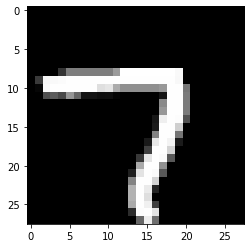

In [4]:

def im_convert(tensor, rescale=False):
    tensor = tensor.view(1, image_size, image_size)
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    if rescale:
        # Rescale image from tanh output (1, -1) to rgb (0, 255)
        image = ((image + 1) * 255 / (2)).astype(np.uint8)
    return image

# Show one image 
dataiter = iter(train_loader)
images, labels = dataiter.next()
image = im_convert(images[0])
plt.imshow(image, cmap="gray")

In [5]:

# Scale image values from -1 to 1 to be close to the output of the tanh function
def scale(x, feature_range=(-1, 1)):
    min, max = feature_range
    x = x * (max-min) + min
    return x

In [6]:
class Discriminator(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        input_features = 1 * image_size * image_size
    
        # Define hidden linear layers
        self.hcl1 = nn.Linear(input_features, 1024)
        self.hcl2 = nn.Linear(1024, 512)
        self.hcl3 = nn.Linear(512, 256)
        self.out = nn.Linear(256, 1)
        # Activation function
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
  
    def forward(self, x):
        x = self.leaky_relu(self.hcl1(x))
        x = self.leaky_relu(self.hcl2(x))
        x = self.leaky_relu(self.hcl3(x))
        x = torch.sigmoid(self.out(x))
        return x

In [7]:
def linear_block(in_features, out_features, batch_norm=True):
    layers = []
    if batch_norm:
        linear_layer = nn.Linear(in_features, out_features, bias=False)
        batch_norm = nn.BatchNorm1d(out_features)
        layers = [linear_layer, batch_norm]
    else:
        layers.append(nn.Linear(in_features, out_features))
    return nn.Sequential(*layers)

In [8]:

class Generator(nn.Module):
    def __init__(self, input_features, image_size):
        super().__init__()
        output_features = 1 * image_size * image_size
    
        # Define hidden linear layers
        self.hcl1 = linear_block(input_features, 256)
        self.hcl2 = linear_block(256, 512)
        self.hcl3 = linear_block(512, 1024)
        self.output = linear_block(1024, output_features)
    
        # Activation function
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
    
    def forward(self, x):
        x = self.leaky_relu(self.hcl1(x))
        x = self.leaky_relu(self.hcl2(x))
        x = self.leaky_relu(self.hcl3(x))
        x = torch.tanh(self.output(x))
        return x

In [9]:
z_size = 100

D = Discriminator(image_size=image_size)
G = Generator(input_features=z_size, image_size=image_size)

In [10]:
if torch.cuda.is_available():
    G = G.cuda()
    D = D.cuda()
    print("GPU available. Moved models to GPU.")
else:
    print("Training on CPU.")

Training on CPU.


In [11]:
def real_loss(predictions, smooth=False):
    batch_size = predictions.shape[0]
    labels = torch.ones(batch_size)
    # Smooth labels for discriminator to weaken learning
    if smooth:
        labels = labels * 0.9
    # We use the binary cross entropy loss | Model has a sigmoid function
    criterion = nn.BCELoss()
    # Move models to GPU if available
    if torch.cuda.is_available():
        labels = labels.cuda()
        criterion = criterion.cuda()
    loss = criterion(predictions.squeeze(), labels)
    return loss

def fake_loss(predictions):
    batch_size = predictions.shape[0]
    labels = torch.zeros(batch_size)
    criterion = nn.BCELoss()
    # Move models to GPU if available
    if torch.cuda.is_available():
        labels = labels.cuda()
        criterion = criterion.cuda()
    loss = criterion(predictions.squeeze(), labels)
    return loss

In [12]:
def random_vector(batch_size, length):
    # Sample from a Gaussian distribution
    z_vec = torch.randn(batch_size, length).float()
    if torch.cuda.is_available():
        z_vec = z_vec.cuda()
    return z_vec

In [13]:

#-----TRAINING PARAMETERS-----
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
#-----------------------------

d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=[beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=[beta1, beta2])

In [14]:
def train_discriminator(generator, discriminator, optimizer, real_data, batch_size, z_size):
    # Reshape real_data to vector
    real_data = real_data.view(batch_size, -1)
    # Rescale real_data to range -1 - 1
    real_data = scale(real_data)
    
    # Reset gradients and set model to training mode
    optimizer.zero_grad()
    discriminator.train()
    
    # Train on real data
    real_data_logits = discriminator.forward(real_data)
    loss_real = real_loss(real_data_logits, smooth=True)
    # Generate fake data
    z_vec = random_vector(batch_size, z_size)
    fake_data = generator.forward(z_vec)
    # Train on fake data
    fake_data_logits = discriminator.forward(fake_data)
    loss_fake = fake_loss(fake_data_logits)
    # Calculate total loss
    total_loss = loss_real + loss_fake
    total_loss.backward()
    optimizer.step()
    
    return total_loss

In [15]:

def train_generator(generator, discriminator, optimizer, batch_size, z_size):
    # Reset gradients and set model to training mode
    optimizer.zero_grad()
    generator.train()
    # Generate fake data
    z_vec = random_vector(batch_size, z_size)
    fake_data = generator.forward(z_vec)
    # Train generator with output of discriminator
    discriminator_logits = discriminator.forward(fake_data)
    # Reverse labels
    loss = real_loss(discriminator_logits)
    loss.backward()
    optimizer.step()
    return loss

Epoch: 0, Batch: 0, D-Loss: 1.3809223175048828, G-Loss: 0.7330712676048279


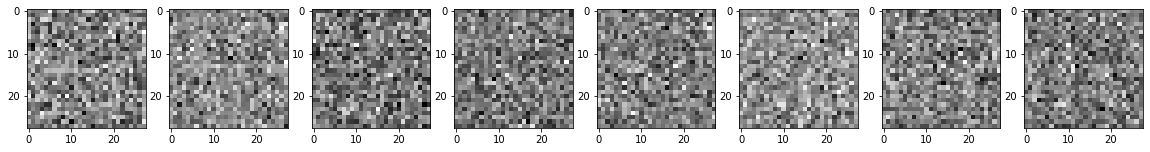

Epoch: 0, Batch: 200, D-Loss: 1.0304529666900635, G-Loss: 9.68118667602539


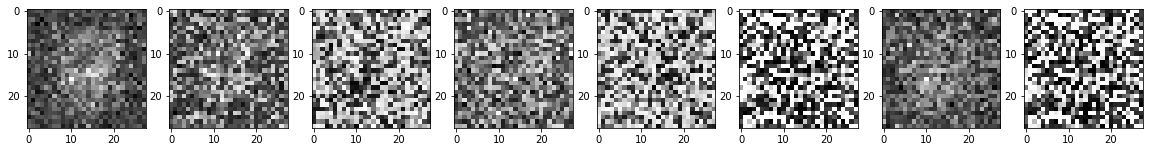

Epoch: 0, Batch: 400, D-Loss: 0.4195954501628876, G-Loss: 18.711532592773438


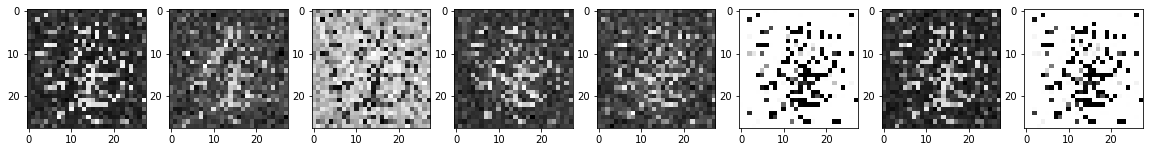

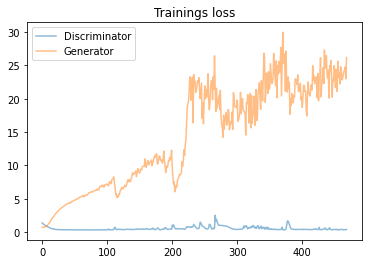

Epoch: 1, Batch: 0, D-Loss: 0.3461485207080841, G-Loss: 26.109283447265625


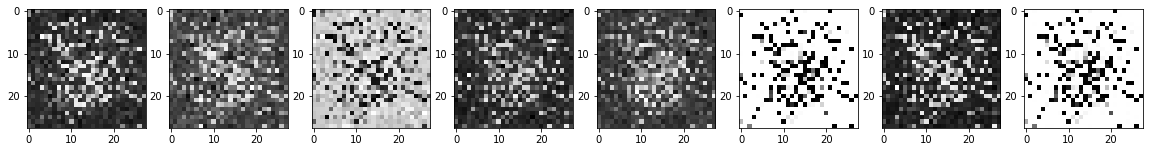

Epoch: 1, Batch: 200, D-Loss: 0.7664673924446106, G-Loss: 16.697879791259766


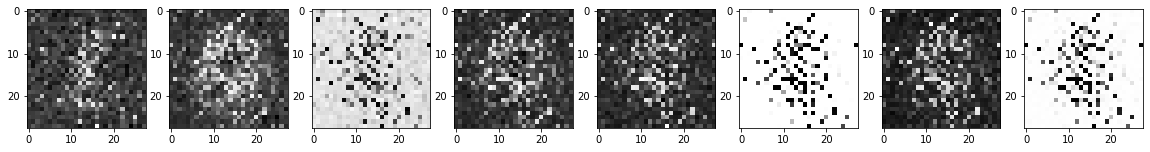

Epoch: 1, Batch: 400, D-Loss: 0.40677016973495483, G-Loss: 17.596115112304688


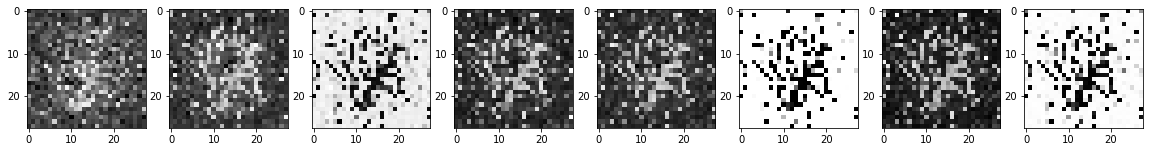

Epoch: 2, Batch: 0, D-Loss: 0.3567450940608978, G-Loss: 20.483060836791992


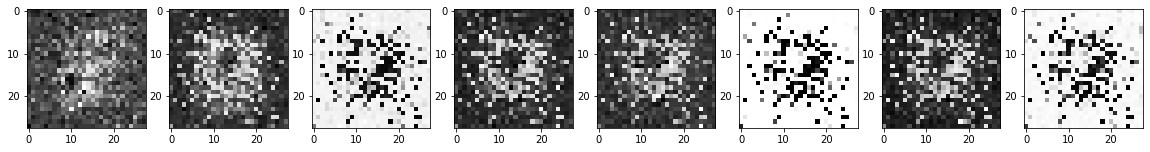

Epoch: 2, Batch: 200, D-Loss: 0.9538403153419495, G-Loss: 11.211419105529785


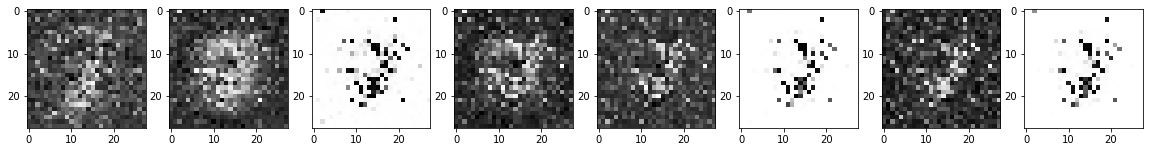

Epoch: 2, Batch: 400, D-Loss: 0.8108357191085815, G-Loss: 20.173370361328125


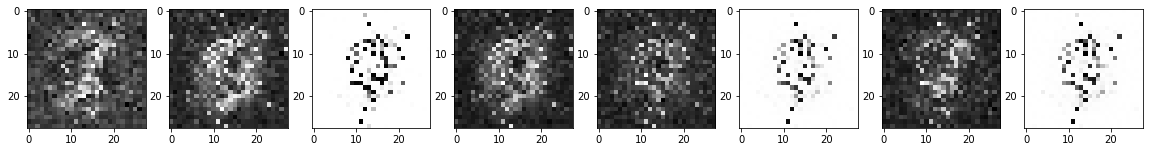

Epoch: 3, Batch: 0, D-Loss: 0.35559672117233276, G-Loss: 22.40154457092285


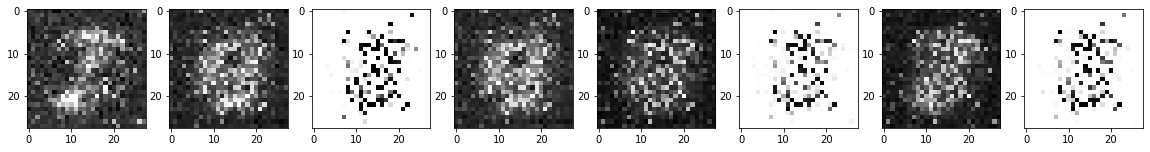

Epoch: 3, Batch: 200, D-Loss: 0.41028934717178345, G-Loss: 15.138998031616211


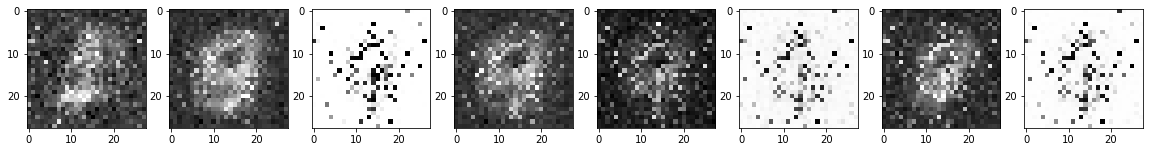

Epoch: 3, Batch: 400, D-Loss: 0.33835580945014954, G-Loss: 18.660449981689453


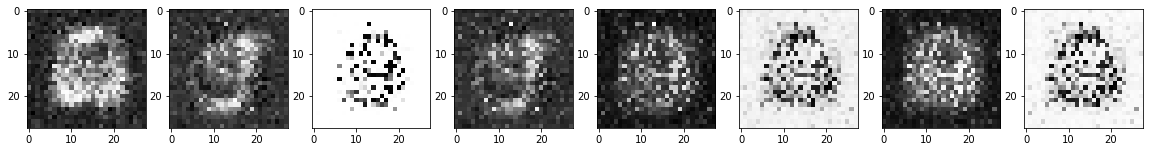

In [16]:
# After how many batches should generated sample images be shown?
epochs = 4
print_every = 200
# How many images should be shown?
sample_size = 8
# After how many epochs should the loss be plotted?
plot_every = 5
# Create some sample noise
sample_noise = random_vector(sample_size, z_size)
#-------------------------

# Keep track of losses
d_losses = []
g_losses = []

for e in range(epochs):
    for batch_i, (images, _) in enumerate(train_loader):
        batch_size = images.shape[0]
        # Move images to GPU if available
        if torch.cuda.is_available():
            images = images.cuda()
        # Train discriminator
        d_loss = train_discriminator(G, D, d_optimizer, images, batch_size, z_size)
        # Train generator
        g_loss = train_generator(G, D, g_optimizer, batch_size, z_size)
        
        # Keep track of losses
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
        # Print some sample pictures
        if (batch_i % print_every == 0):
            print("Epoch: {}, Batch: {}, D-Loss: {}, G-Loss: {}".format(e, batch_i, d_loss, g_loss))
            # Make sample generation
            G.eval()
            fig, axes = plt.subplots(1, sample_size, figsize=(20, 10))
            # Generate predictions
            predictions = G.forward(sample_noise)
            for i in range(sample_size):
                axes[i].imshow(im_convert(predictions[i], rescale=True), cmap="gray")
            plt.show()
    if (e % plot_every == 0):
        # Print losses
        plt.plot(d_losses, label="Discriminator", alpha=0.5)
        plt.plot(g_losses, label="Generator", alpha=0.5)
        plt.title("Trainings loss")
        plt.legend()
        plt.show()

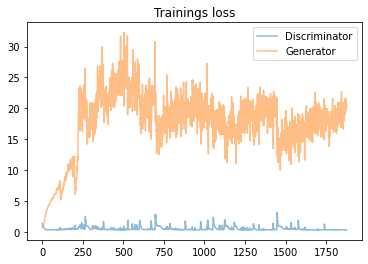

In [17]:
plt.plot(d_losses, label="Discriminator", alpha=0.5)
plt.plot(g_losses, label="Generator", alpha=0.5)
plt.title("Trainings loss")
plt.legend()
plt.show()

In [18]:

def show_samples(num_samples):
    G.eval()
    z_vec = random_vector(num_samples, z_size)
    predictions = G.forward(z_vec)
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 10))
    for i in range(num_samples):
        axes[i].imshow(im_convert(predictions[i], rescale=True), cmap="gray")              
    plt.show()

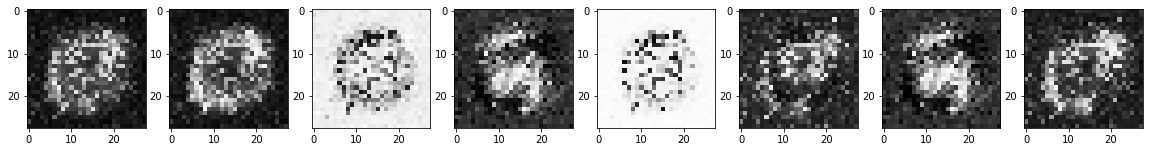

In [22]:
show_samples(8)